In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten

# Define function to create the neural network model
def create_nn_model(vocab_size: int, embedding_dim: int, max_length: int, num_of_dense: int) -> Model:
    """
    Creates a neural network model that processes user prompts using an embedding layer,
    concatenates it with function ratings, and passes through dense layers.

    Args:
        vocab_size (int): Size of the vocabulary for embedding.
        embedding_dim (int): Dimensionality of the embedding layer.
        max_length (int): Maximum length of input sequences.
        num_of_dense (int): Number of dense layers before concatenation.

    Returns:
        Model: A compiled TensorFlow model.
    """
    # Text input (user prompt)
    text_input = Input(shape=(max_length,), name="text_input")
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(text_input)
    flatten = Flatten()(embedding)

    # Dense layers for text input
    num_neurons = 2**12  # Start with 4096 neurons
    x = flatten
    for _ in range(num_of_dense):
        num_neurons = max(1, int(num_neurons / 2))  # Ensure integer neurons, minimum of 1
        x = Dense(num_neurons, activation='relu')(x)

    # Numeric input (func_rating)
    func_rating_input = Input(shape=(1,), name="func_rating_input")
    y = Dense(32, activation='relu')(func_rating_input)

    # Concatenate both paths
    concatenated = Concatenate()([x, y])
    # output = Dense(1, activation='linear', name="output")(concatenated)
    output = Dense(6, activation='softmax', name="output")(concatenated)

    # Define and compile the model
    model = Model(inputs=[text_input, func_rating_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [3]:
import pandas as pd

df = pd.read_csv('combined_data.csv')

df["custom_rating"].unique()


array([3, 4, 2, 5, 1, 0])

In [4]:
df.shape

(322, 4)

In [5]:
# Tokenize and prepare data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["user_prompt"])
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(x.split()) for x in df["user_prompt"]])
embedding_dim = 16

# Convert text data into sequences
X_text = tokenizer.texts_to_sequences(df["user_prompt"])
X_text = pad_sequences(X_text, maxlen=max_length, padding='post')
print(X_text.shape)

# Numeric input
X_func_rating = np.array(df["func_rating"]).reshape(-1, 1)
print(X_func_rating.shape)

# Target variable
y = np.array(df["custom_rating"]).reshape(-1, 1)
print(y.shape)

(322, 26)
(322, 1)
(322, 1)


In [6]:
df["custom_rating"].unique()

array([3, 4, 2, 5, 1, 0])

In [7]:
from keras.utils import to_categorical

# Assuming y is your array of class labels shaped as (20, 1)
# Convert labels to one-hot encoding
y_one_hot = to_categorical(y)

# Check the new shape of y_one_hot
print(y_one_hot.shape)

(322, 6)


##Instantiate Model

In [8]:
# Create the model
num_of_dense_layers = 3  # Example: 2 dense layers before concatenation
model = create_nn_model(vocab_size, embedding_dim, max_length, num_of_dense_layers)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# **Training**

In [9]:
%%time

# Train the model
model.fit(
    {"text_input": X_text, "func_rating_input": X_func_rating},
    y_one_hot,
    epochs=80,
    batch_size=2,
    validation_split=0.1,
    verbose=2
)

Epoch 1/80
145/145 - 12s - 84ms/step - accuracy: 0.5190 - loss: 1.4271 - val_accuracy: 0.4545 - val_loss: 1.4103
Epoch 2/80
145/145 - 10s - 67ms/step - accuracy: 0.5433 - loss: 1.1841 - val_accuracy: 0.4242 - val_loss: 1.3641
Epoch 3/80
145/145 - 10s - 68ms/step - accuracy: 0.6367 - loss: 0.9455 - val_accuracy: 0.3636 - val_loss: 1.4915
Epoch 4/80
145/145 - 10s - 69ms/step - accuracy: 0.7232 - loss: 0.7303 - val_accuracy: 0.4242 - val_loss: 1.4436
Epoch 5/80
145/145 - 9s - 61ms/step - accuracy: 0.7924 - loss: 0.6037 - val_accuracy: 0.3333 - val_loss: 2.2712
Epoch 6/80
145/145 - 9s - 61ms/step - accuracy: 0.8339 - loss: 0.4836 - val_accuracy: 0.3030 - val_loss: 1.5668
Epoch 7/80
145/145 - 10s - 67ms/step - accuracy: 0.8754 - loss: 0.3841 - val_accuracy: 0.4242 - val_loss: 1.4295
Epoch 8/80
145/145 - 9s - 60ms/step - accuracy: 0.8720 - loss: 0.3923 - val_accuracy: 0.4242 - val_loss: 1.4722
Epoch 9/80
145/145 - 11s - 76ms/step - accuracy: 0.8824 - loss: 0.3003 - val_accuracy: 0.1515 - val

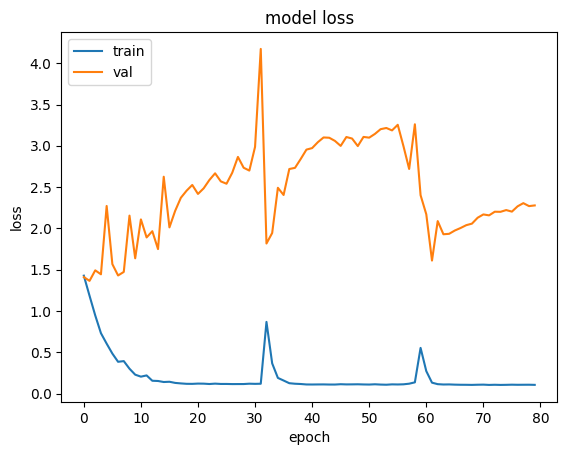

In [16]:
# Plot error
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 26)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 26, 16)         │         14,528 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 416)            │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2048)           │        854,016 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      2,098,176 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │             64 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 544)            │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 6)              │          3,270 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,484,564 (40.00 MB)

 Trainable params: 3,494,854 (13.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,989,710 (26.66 MB)

In [18]:
! pip install --upgrade huggingface_hub

In [19]:
from huggingface_hub import HfApi, login

hf_token = "your_token"  # Replace with your actual token

# Log in to Hugging Face
login(token=hf_token)

hf_username = "bhairavee37"  # Replace with your username
repo_name = "my-nn-model"
repo_id = f"{hf_username}/{repo_name}"

api = HfApi()

# Create the repository
api.create_repo(repo_id=repo_id, exist_ok=True)

print(f"Repository created: https://huggingface.co/{repo_id}")

Repository created: https://huggingface.co/bhairavee37/my-nn-model


In [20]:
import pickle
import os
from huggingface_hub import HfApi
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Define save directory
model_dir = "./saved_model"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, "model.keras")
model.save(model_path)

# Save the tokenizer as a pickle file
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Upload model and tokenizer to Hugging Face
repo_id = f"{hf_username}/{repo_name}"  # Change as needed
api = HfApi()

api.upload_file(path_or_fileobj=model_path, path_in_repo="model.keras", repo_id=repo_id)
api.upload_file(path_or_fileobj=tokenizer_path, path_in_repo="tokenizer.pkl", repo_id=repo_id)

print(f"Model and tokenizer successfully pushed to: https://huggingface.co/{repo_id}")

model.keras:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer successfully pushed to: https://huggingface.co/bhairavee37/my-nn-model


In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import hf_hub_download

# Set Keras backend to JAX (Optional, only needed if you want to experiment with JAX backend)
os.environ["KERAS_BACKEND"] = "jax"

# Define repo ID and model filename
# repo_id = "eagle0504/my-tf-nn-model" # we already defined it above
filename = "model.keras"  # Ensure this matches what was uploaded

# Download the model
model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the Keras model
new_model = keras.models.load_model(model_path)

print("Model loaded successfully!")

model.keras:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Model loaded successfully!


In [22]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 26)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 26, 16)         │         14,528 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 416)            │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2048)           │        854,016 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      2,098,176 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │             64 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 544)            │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 6)              │          3,270 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,484,564 (40.00 MB)

 Trainable params: 3,494,854 (13.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,989,710 (26.66 MB)

In [23]:
import pickle
from huggingface_hub import hf_hub_download
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define repo details
# repo_id = "eagle0504/my-tf-nn-model" # we already defined above

# Download model
# model_path = hf_hub_download(repo_id=repo_id, filename="model.keras")
# new_model = keras.models.load_model(model_path)

# Download tokenizer
tokenizer_path = hf_hub_download(repo_id=repo_id, filename="tokenizer.pkl")

# Load the tokenizer
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

print("Model and tokenizer loaded successfully!")

# Sample test data
test_texts = [
    "How to improve focus and concentration?",
    "What are the side effects of lack of sleep?",
]

# Preprocess test data using the loaded tokenizer
max_length = model.input_shape[0][1]  # Get max_length from model input shape
X_text_test = tokenizer.texts_to_sequences(test_texts)
X_text_test = pad_sequences(X_text_test, maxlen=max_length, padding='post')

# Dummy numeric input (func_rating)
X_func_test = np.array([5, 4]).reshape(-1, 1)

# Make predictions
predictions = new_model.predict({"text_input": X_text_test, "func_rating_input": X_func_test})

# Display results
for i, text in enumerate(test_texts):
    print(f"Prompt: {text}")
    print(f"Predicted Rating: {predictions[i][0]:.2f}")
    print("-" * 50)

tokenizer.pkl:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

Model and tokenizer loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Prompt: How to improve focus and concentration?
Predicted Rating: 0.00
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Rating: 0.00
--------------------------------------------------
